In [10]:
import arviz
import bambi
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.stats as ss

import wmfdata as wmf

In [4]:
wmf.charting.set_mpl_style()

In [5]:
session = pd.read_parquet("data/experiment_session.parquet")

In [ ]:
session.head()

In [7]:
user = pd.read_parquet("data/experiment_user.parquet")

In [ ]:
user.head()

# Basic tests

In [15]:
print(f"Control mean session length: {round(control_user['avg_session_min'].mean(), 3)} min")
print(f"Trending articles mean session length: {round(trending_articles_user['avg_session_min'].mean(), 3)} min")

Control mean session length: 2.258 min
Trending articles mean session length: 2.598 min


In [11]:
ss.ttest_ind(control_user["avg_session_min"], trending_articles_user["avg_session_min"], equal_var=False)

Ttest_indResult(statistic=-7.163897096805063, pvalue=7.980442634422224e-13)

In [17]:
print(f"Control mean sessions: {round(control_user['sessions'].mean(), 3)}")
print(f"Trending articles mean sessions: {round(trending_articles_user['sessions'].mean(), 3)}")

Control mean sessions: 1.669
Trending articles mean sessions: 1.697


In [39]:
ss.ttest_ind(control_user["sessions"], trending_articles_user["sessions"], equal_var=False)

Ttest_indResult(statistic=-1.5305251492545688, pvalue=0.1258948236860418)

In [19]:
ss.mannwhitneyu(control_user["sessions"], trending_articles_user["sessions"])

MannwhitneyuResult(statistic=191544034.0, pvalue=0.0046126993693656896)

# User-level model

# Attempt 1

In [10]:
model = bambi.Model(
    "sessions ~ lg_min_in_experiment + country + experiment_group + (experiment_group|country)",
    user,
    family="poisson"
)

results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [experiment_group[trending-articles]|country_offset, experiment_group[trending-articles]|country_sigma, 1|country_offset, 1|country_sigma, experiment_group, country, lg_min_in_experiment, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5684 seconds.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 226 divergences after tuning. Increase `target_accept` or reparameterize.
There were 825 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.06481254239845938, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


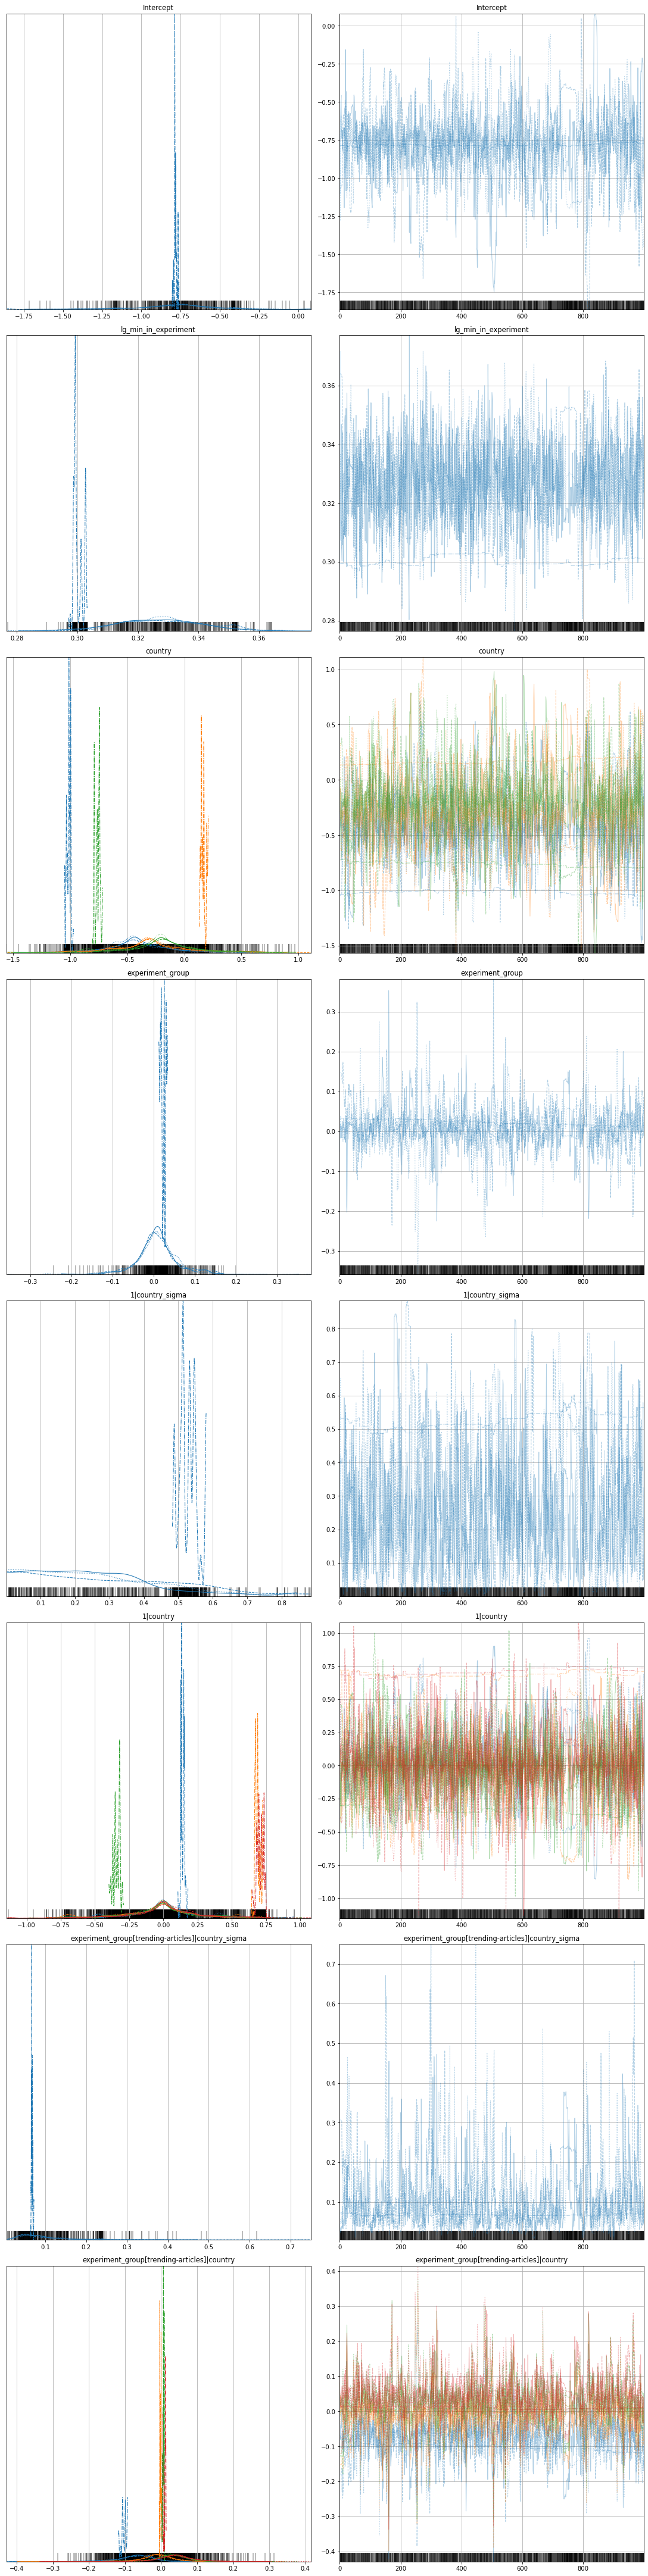

In [15]:
arviz.plot_trace(
    results
)

fig = plt.gcf()
fig.set_size_inches(15, 60);

# Attempt 2

In [9]:
sessions_model_2 = bambi.Model(
    "sessions ~ lg_min_in_experiment + country + experiment_group + (experiment_group|country)",
    user,
    family="poisson"
)

sessions_model_2.build()

with sessions_model_2.backend.model:
    custom_step = pm.step_methods.hmc.nuts.NUTS(target_accept=0.95)

session_results_2 = sessions_model_2.fit(step=custom_step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [experiment_group[trending-articles]|country_offset, experiment_group[trending-articles]|country_sigma, 1|country_offset, 1|country_sigma, experiment_group, country, lg_min_in_experiment, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27168 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


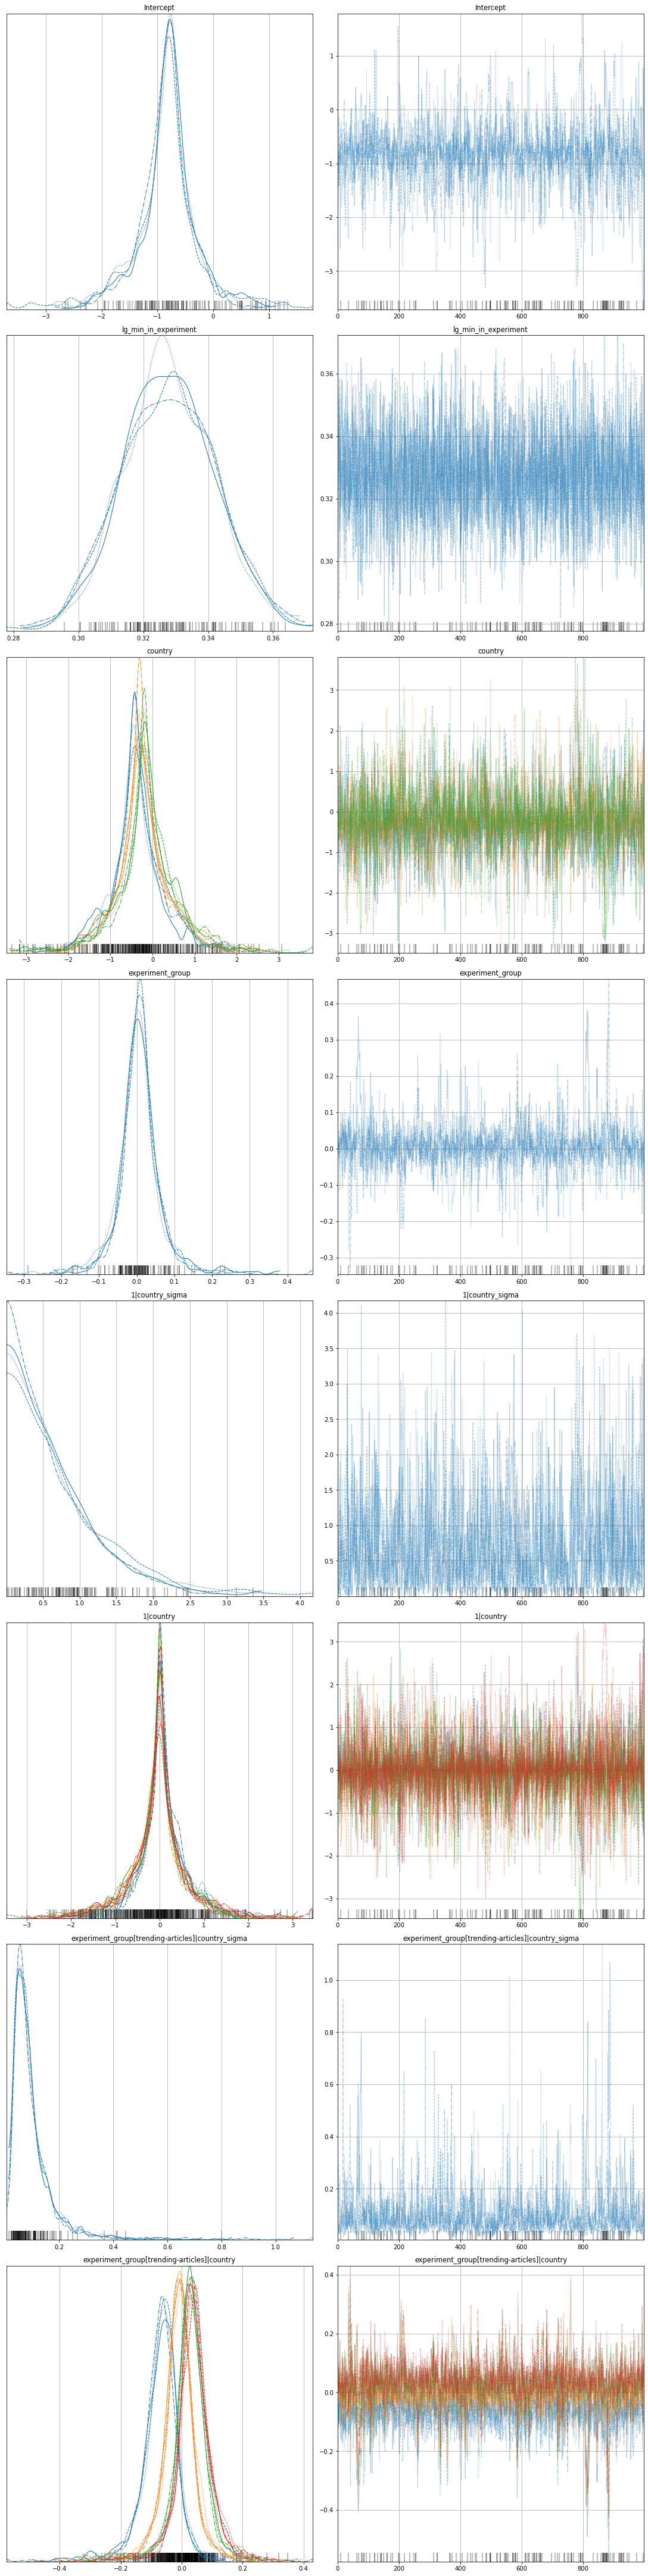

In [12]:
arviz.plot_trace(
    session_results_2
)

fig = plt.gcf()
fig.set_size_inches(15, 60);

In [ ]:
sessions_model_2 = bambi.Model(
    "sessions ~ lg_min_in_experiment + country + experiment_group + (experiment_group|country)",
    user,
    family="wald"
)

sessions_model_2.build()

# with sessions_model_2.backend.model:
#     custom_step = pm.step_methods.hmc.nuts.NUTS(target_accept=0.95)

session_results_2 = sessions_model_2.fit(step=custom_step)

# Session-level model

In [ ]:
%%time
model = bambi.Model(
    # Nest user ID within country 
    # Try removing varying effect of experiment_group
    "page_visible_time ~ experiment_group + country + (experiment_group|country) + (1|user_id)",
    session_2,
    # Why doesn't "wald" work?
    family="gamma"
)

results = model.fit(
    # Need this because reasons (https://discourse.pymc.io/t/how-to-track-a-nan-energy/2253/4)
    init="adapt_diag"
)

/home/neilpquinn-wmf/.conda/envs/2021-06-10T22.32.37_neilpquinn-wmf/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
/home/neilpquinn-wmf/.conda/envs/2021-06-10T22.32.37_neilpquinn-wmf/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
/home/neilpquinn-wmf/.conda/envs/2021-06-10T22.32.37_neilpquinn-wmf/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
/home/neilpquinn-wmf/.conda/envs/2021-06-10T22.32.37_neilpquinn-wmf/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The inverse_power link function does not respect the d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1704 seconds.


In [41]:
model

Formula: page_visible_time ~ experiment_group + country + (experiment_group|country) + (1|user_id)
Family name: Gamma
Link: inverse
Observations: 26609
Priors:
  Intercept ~ Normal(mu: 0.2495884, sigma: 0.62823398)
  experiment_group ~ Normal(mu: 0, sigma: 0.00604206)
  country ~ Normal(mu: [0 0 0], sigma: [0.00130732 0.00231152 0.00576773])
  1|country ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.36271106))
  experiment_group[trending-articles]|country ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.00604206))
  1|user_id ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.36271106))
  alpha ~ HalfCauchy(beta: 1)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

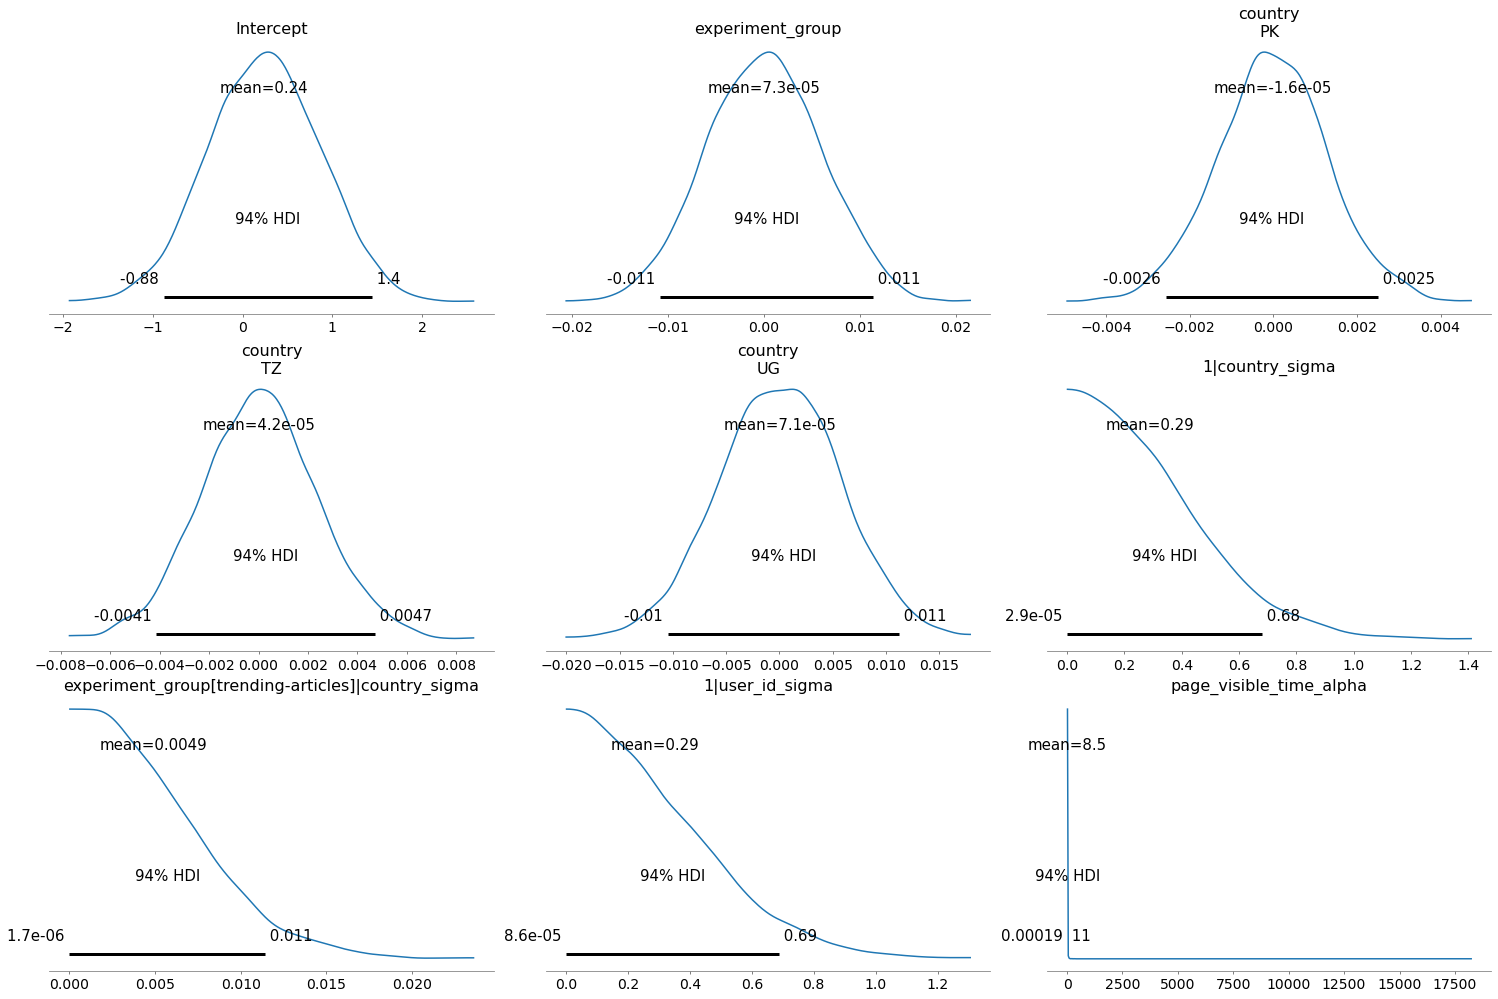

In [42]:
model.plot_priors();

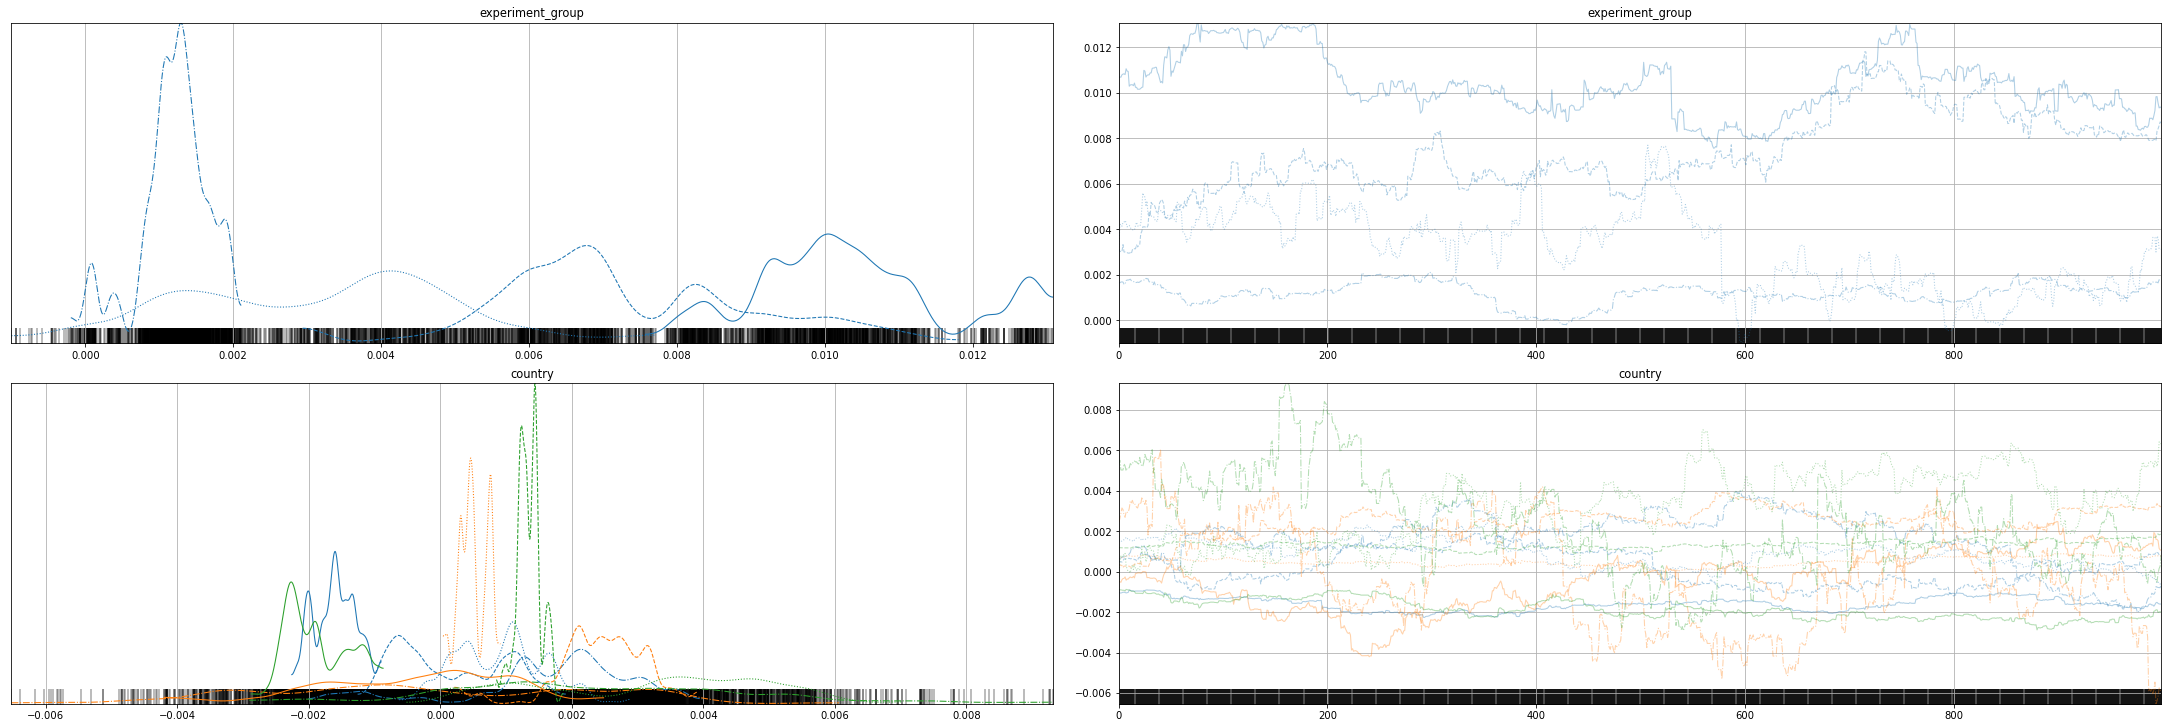

In [62]:
arviz.plot_trace(
    results,
    var_names=["experiment_group", "country"]
)

fig = plt.gcf()
fig.set_size_inches(30, 10)

pm_model = model.backend.model

In [38]:
pm_model.check_test_point()

INFO (theano.gof.compilelock): Refreshing lock /srv/home/neilpquinn-wmf/.theano/compiledir_Linux-5.8-bpo.2-amd64-x86_64-with-debian-10.9--3.7.10-64/lock_dir/lock


Intercept                                                     -0.45
experiment_group                                               4.19
country                                                       15.11
1|country_sigma_log__                                         -0.77
1|country_offset                                              -3.68
experiment_group[trending-articles]|country_sigma_log__       -0.77
experiment_group[trending-articles]|country_offset            -3.68
1|user_id_sigma_log__                                         -0.77
1|user_id_offset                                          -16859.77
page_visible_time_alpha_log__                                 -1.14
page_visible_time                                         -63540.75
Name: Log-probability of test_point, dtype: float64

# Minor caveats
* After the scheduled publication of recommendations on 2 June at 03:00 UTC, an infrastructure issue prevented new recommendations from being published (although the existing recommendations continued to be served to app users). The issue was fixed and updated set of recommendations were published on 4 June at 23:00 UTC, followed by scheduled updates as normal.